# Symbolic workings with cardinal B-splines

In this notebook, we use `sympy`, a python symbolic toolbox, to compute 
functional correlations between B-splines and their derivatives.

The values of these correlations -- evaluated at integer coordinates --
are used in the computation of a family of energies from spline-encoded
flow fields.

In [141]:
from sympy import *
import sympy

SymPy struggles with products of piecewise functions, so we implement our 
own version.

It has a bunch of assumptions on the piecewise structure of `f` and `g`,
so do not use this function in the wild! In particular we asssume that all
piecewise conditions are of the form `x < number`.

In [81]:

def product(f, g):
    """
    Symbolic product between two piecewise functions,
    whose conditions are of the form `x < number`.
    """
    fargs, gargs = list(f.args), list(g.args)
    args = []
    while True:
        if fargs and isinstance(fargs[0][1], StrictLessThan):
            farg = (fargs[0][0], simplify(fargs[0][1]))
            flim = float(farg[1].args[1])
            if gargs and isinstance(gargs[0][1], StrictLessThan):
                garg = (gargs[0][0], simplify(gargs[0][1]))
                glim = float(garg[1].args[1])
                if flim < glim:
                    arg = (farg[0] * garg[0], farg[1])
                    if args and arg[0] == args[-1][0]:
                        args.pop(-1)
                    args.append(arg)
                    fargs.pop(0)
                    continue
                if glim < flim:
                    arg = (farg[0] * garg[0], garg[1])
                    if args and arg[0] == args[-1][0]:
                        args.pop(-1)
                    args.append(arg)
                    gargs.pop(0)
                    continue
                assert flim == glim
                arg = (farg[0] * garg[0], farg[1])
                if args and arg[0] == args[-1][0]:
                    print('pop', args.pop(-1))
                args.append(arg)
                fargs.pop(0)
                gargs.pop(0)
                continue
            elif gargs:
                arg = (farg[0] * gargs[0][0], farg[1])
                if args and arg[0] == args[-1][0]:
                    args.pop(-1)
                args.append(arg)
                fargs.pop(0)
                continue
            else:
                if args and farg[0] == args[-1][0]:
                    args.pop(-1)
                args.append(farg)
                fargs.pop(0)
                continue
        elif gargs and isinstance(gargs[0][1], StrictLessThan):
            garg = (gargs[0][0], simplify(gargs[0][1]))
            if fargs:
                arg = (fargs[0][0] * garg[0], garg[1])
                if args and arg[0] == args[-1][0]:
                    args.pop(-1)
                args.append(arg)
                gargs.pop(0)
                continue
            else:
                if args and garg[0] == args[-1][0]:
                    args.pop(-1)
                args.append(garg)
                gargs.pop(0)
                continue
        elif fargs and gargs:
            arg = (fargs[0][0] * gargs[0][0], fargs[0][1])
            if args and arg[0] == args[-1][0]:
                args.pop(-1)
            args.append(arg)
            fargs.pop(0)
            gargs.pop(0)
            continue
        elif fargs:
            if args and fargs[0][0] == args[-1][0]:
                args.pop(-1)
            args.append(fargs.pop(0))
            continue
        elif gargs:
            if args and gargs[0][0] == args[-1][0]:
                args.pop(-1)
            args.append(gargs.pop(0))
            continue
        break
    return Piecewise(*args)

Let's define cardinal B-splines (centered on zero), using the recursive 
formula. We also implement their first and second derivatives manually
(instead of using `sympy.diff`).

In [24]:
x = Symbol('x', real=True)
half = S.Half

# Zero-th order B-spline (box)
symb0 = Piecewise((0, x < -half), (1, x < half), (0, True))


def call(f, val):
    """Evaluate a symbolic function"""
    return f.subs(x, val)


def make_symb(n):
    """B-spline of order `n`"""
    if n == 0:
        return symb0

    bprev = make_symb(n-1)
    halflength = (n + 1) * half
    return simplify((
        call(bprev, x + half) * (halflength + x) +
        call(bprev, x - half) * (halflength - x)
    ) / n)


def make_symg(n):
    """Gradient of the B-spline of order `n`"""
    if n == 0:
        return S('0')

    bprev = make_symb(n-1)
    gprev = make_symg(n-1)
    halflength = (n + 1) * half
    return simplify((
        call(gprev, x + half) * (halflength + x) +
        call(gprev, x - half) * (halflength - x) +
        call(bprev, x + half) - call(bprev, x - half)
    ) / n)


def make_symh(n):
    """Hessian of the B-spline of order `n`"""
    if n == 0:
        return S('0')

    gprev = make_symg(n-1)
    hprev = make_symh(n-1)
    halflength = (n + 1) * half
    return simplify((
        call(hprev, x + half) * (halflength + x) +
        call(hprev, x - half) * (halflength - x) +
        (call(gprev, x + half) - call(gprev, x - half)) * 2
    ) / n)


def corr(i, n, f, g=None):
    """Evaluate (f * g)(i)   (correlation integrated on [-n, n])"""
    if g is None:
        g = f
    f = simplify(f)
    g = simplify(g)
    gshift = call(g, x - i)
    fg = product(f, gshift)
    fg = simplify(fg)
    return integrate(fg, (x, -n, n))


In [14]:
# compute analytical autocorrelations at integer locations
MIN_ORDER = 3   # included
MAX_ORDER = 4   # excluded
for n in range(MIN_ORDER, MAX_ORDER):
    print(f'--- order {n} ---')
    f, ff = make_symb(n), []
    print('ff = [', end='', flush=True)
    for i in range(-n, n+1):
        ff += [corr(i, n, f)]
        print(ff[-1], end=', ' if i < n else ']\n', flush=True)
    if n < 1: continue
    g, gg = make_symg(n), []
    print('gg = [', end='', flush=True)
    for i in range(-n, n+1):
        gg += [corr(i, n, g)]
        print(gg[-1], end=', ' if i < n else ']\n', flush=True)
    fg = []
    print('fg = [', end='', flush=True)
    for i in range(-n, n+1):
        fg += [corr(i, n, f, g)]
        print(fg[-1], end=', ' if i < n else ']\n', flush=True)
    if n < 2: continue
    h, hh = make_symh(n), []
    print('hh = [', end='', flush=True)
    for i in range(-n, n+1):
        hh += [corr(i, n, h)]
        print(hh[-1], end=', ' if i < n else ']\n', flush=True)

--- order 3 ---
ff = [1/5040, 1/42, 397/1680, 151/315, 397/1680, 1/42, 1/5040]
gg = [-1/120, -1/5, -1/8, 2/3, -1/8, -1/5, -1/120]
fg = [-1/720, -7/90, -49/144, 0, 49/144, 7/90, 1/720]
hh = [1/6, 0, -3/2, 8/3, -3/2, 0, 1/6]


In [7]:
# compute spline coefficients at integer locations + discrete correlations
MIN_ORDER = 0   # included
MAX_ORDER = 0   # excluded
for n in range(MIN_ORDER, MAX_ORDER):
    print(f'--- order {n} ---')
    f, ff = make_symb(n), []
    print('f  = [', end='', flush=True)
    for i in range(0, (n+2)//2):
        ff += [call(f, i)]
        print(ff[-1], end=', ' if i < (n+2)//2-1 else ']\n', flush=True)
    fullf = ff[1:][::-1] + ff
    print('ff = [', end='', flush=True)
    for i in reversed(range(1, len(fullf)+1)):
        c = sum(a*b for a, b in zip(fullf[:i], fullf[-i:]))
        print(c, end=', ' if i > 1 else ']\n', flush=True)
    if n < 1: continue
    g, gg = make_symg(n), []
    print('g  = [', end='', flush=True)
    for i in range(0, (n+2)//2):
        gg += [call(g, i)]
        print(gg[-1], end=', ' if i < (n+2)//2-1 else ']\n', flush=True)
    fullg = [-foo for foo in gg[1:][::-1]] + gg
    print('gg = [', end='', flush=True)
    for i in reversed(range(1, len(fullg)+1)):
        c = sum(a*b for a, b in zip(fullg[:i], fullg[-i:]))
        print(c, end=', ' if i > 1 else ']\n', flush=True)
    print('fg = [', end='', flush=True)
    for i in reversed(range(1, len(fullg)+1)):
        c = sum(a*b for a, b in zip(fullf[:i], fullg[-i:]))
        print(c, end=', ' if i > 1 else ']\n', flush=True)
    if n < 2: continue
    h, hh = make_symh(n), []
    print('h  = [', end='', flush=True)
    for i in range(0, (n+2)//2):
        hh += [call(h, i)]
        print(hh[-1], end=', ' if i < (n+2)//2-1 else ']\n', flush=True)
    fullh = hh[1:][::-1] + hh
    print('hh = [', end='', flush=True)
    for i in reversed(range(1, len(fullh)+1)):
        c = sum(a*b for a, b in zip(fullh[:i], fullh[-i:]))
        print(c, end=', ' if i > 1 else ']\n', flush=True)

In [85]:
# compute autocorrelations between splines at different scales
# (used for least-squares upsampling)
MIN_ORDER = 3   # included
MAX_ORDER = 4   # excluded
for n in range(MIN_ORDER, MAX_ORDER):
    print(f'===  order {n} ===')
    f = make_symb(n)
    for factor in [2, 4, 8]:
        print(f'--- factor {factor} ---')
        g = call(f, x / factor)
        c = []
        print('ff_evn = [', end='', flush=True)
        for i in range(-n, n+1):
            c += [corr(2*i+half, 2*n, f, g)]
            print(c[-1], end=', ' if i < n else ']\n', flush=True)
        print('ff_odd = [', end='', flush=True)
        for i in range(-n, n+1):
            c += [corr(2*i-half, 2*n, f, g)]
            print(c[-1], end=', ' if i < n else ']\n', flush=True)

===  order 3 ===
--- factor 2 ---
ff_evn = [1/5160960, 69379/5160960, 835637/2580480, 1451347/2580480, 515429/5160960, 2183/5160960, 0]
ff_odd = [0, 2183/5160960, 515429/5160960, 1451347/2580480, 835637/2580480, 69379/5160960, 1/5160960]
--- factor 4 ---
ff_evn = [487199/10321920, 2501017/10321920, 1246187/2293760, 4372423/6881280, 4095839/10321920, 1244377/10321920, 524161/41287680]
ff_odd = [524161/41287680, 1244377/10321920, 4095839/10321920, 4372423/6881280, 1246187/2293760, 2501017/10321920, 487199/10321920]
--- factor 8 ---
ff_evn = [8765/24576, 12665/24576, 34740161/55050240, 12078061/18350080, 14291/24576, 10775/24576, 22777439/82575360]
ff_odd = [22777439/82575360, 10775/24576, 14291/24576, 12078061/18350080, 34740161/55050240, 12665/24576, 8765/24576]


In [149]:
from fractions import Fraction
for i in range(8):
    print(f'    # order {i}')
    print('    [', end='')
    for i, (P, C) in enumerate(make_symb(i).args):
        first = (i == 0)
        last = (i == len(make_symb(i).args) - 1)
        if len(C.args) > 1:
            C = C.args[1]
        P = poly(P, x, domain='QQ').all_coeffs()
        P = list(map(Fraction, P))
        P = ', '.join([f'R({p.numerator}, {p.denominator})' for p in P[::-1]])
        P = '[' + P + ']'
        if C is not True and not isinstance(C, sympy.logic.boolalg.BooleanTrue):
            C = Fraction(C)
            C = f'R({C.numerator}, {C.denominator})'
        else:
            C = 'True'
        print(('' if first else '     ') + f'({P}, {C})' + (']' if last else ', '))
    print('    ],')

    # order 0
    [([R(0, 1)], R(-1, 2)), 
     ([R(1, 1)], R(1, 2)), 
     ([R(0, 1)], True), 
    ],
    # order 1
    [([R(0, 1)], R(-1, 1)), 
     ([R(1, 1), R(1, 1)], R(0, 1)), 
     ([R(1, 1), R(-1, 1)], R(1, 1)), 
     ([R(0, 1)], True), 
    ],
    # order 2
    [([R(0, 1)], R(-3, 2)), 
     ([R(9, 8), R(3, 2), R(1, 2)], R(-1, 2)), 
     ([R(3, 4), R(0, 1), R(-1, 1)], R(1, 2)), 
     ([R(9, 8), R(-3, 2), R(1, 2)], R(3, 2)), 


KeyboardInterrupt: 

In [117]:
b3 = Piecewise(
    (0, x < -2),
    ((2 + x) ** 3 / 6, x < -1),
    ((x * x * (-x - 2) * 3 + 4) / 6, x < 0),
    ((x * x * (x - 2) * 3 + 4) / 6, x < 1),
    ((2 - x) ** 3 / 6, x < 2),
    (0, True)
)
b3

Piecewise((0, x < -2), ((x + 2)**3/6, x < -1), (x**2*(-x - 2)/2 + 2/3, x < 0), (x**2*(x - 2)/2 + 2/3, x < 1), ((2 - x)**3/6, x < 2), (0, True))

In [120]:
for foo, _ in b3.args:
    print(Poly(foo, x, domain='QQ').coeffs())
b3

[0]
[1/6, 1, 2, 4/3]
[-1/2, -1, 2/3]
[1/2, -1, 2/3]
[-1/6, 1, -2, 4/3]
[0]


Piecewise((0, x < -2), ((x + 2)**3/6, x < -1), (x**2*(-x - 2)/2 + 2/3, x < 0), (x**2*(x - 2)/2 + 2/3, x < 1), ((2 - x)**3/6, x < 2), (0, True))

In [122]:
for (foo, _), (bar, _) in zip(product(b3, b3).args, b3.args):
    print(Poly(bar, x, domain='QQ'))
    print(Poly(foo, x, domain='QQ'))
product(b3, b3)

Poly(0, x, domain='QQ')
Poly(0, x, domain='QQ')
Poly(1/6*x**3 + x**2 + 2*x + 4/3, x, domain='QQ')
Poly(1/36*x**6 + 1/3*x**5 + 5/3*x**4 + 40/9*x**3 + 20/3*x**2 + 16/3*x + 16/9, x, domain='QQ')
Poly(-1/2*x**3 - x**2 + 2/3, x, domain='QQ')
Poly(1/4*x**6 + x**5 + x**4 - 2/3*x**3 - 4/3*x**2 + 4/9, x, domain='QQ')
Poly(1/2*x**3 - x**2 + 2/3, x, domain='QQ')
Poly(1/4*x**6 - x**5 + x**4 + 2/3*x**3 - 4/3*x**2 + 4/9, x, domain='QQ')
Poly(-1/6*x**3 + x**2 - 2*x + 4/3, x, domain='QQ')
Poly(1/36*x**6 - 1/3*x**5 + 5/3*x**4 - 40/9*x**3 + 20/3*x**2 - 16/3*x + 16/9, x, domain='QQ')
Poly(0, x, domain='QQ')
Poly(0, x, domain='QQ')


Piecewise((0, x < -2), ((x + 2)**6/36, x < -1), ((x**2*(-x - 2)/2 + 2/3)**2, x < 0), ((x**2*(x - 2)/2 + 2/3)**2, x < 1), ((2 - x)**6/36, x < 2), (0, True))

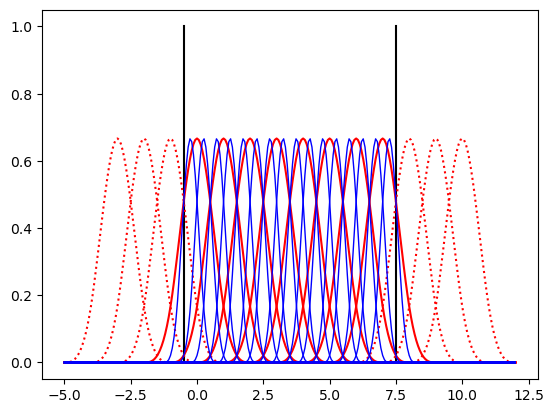

In [57]:
import matplotlib.pyplot as plt
import numpy as np

f = b3
z = np.linspace(-5, 12, 256).tolist()

plt.plot([-0.5]*2, [0, 1], 'black')
plt.plot([+7.5]*2, [0, 1], 'black')
for i in range(-3, 11):
    y = list(map(lambda z: call(f, z-i), z))
    plt.plot(z, y, 'r' + (':' if i < 0 or i >= 8 else '-'))
for i in range(16):
    y = list(map(lambda z: call(f, (z+0.25)*2-i), z))
    plt.plot(z, y, 'b' + (':' if i < 0 or i >= 16 else '-'), linewidth=1)

plt.show()
